In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mylibrary.nnlib as tnn
import mylibrary.splinelib as tsp

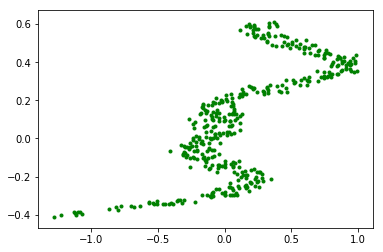

In [2]:
x = np.linspace(0,1,400)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
y = (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
x = x - 0.4 #x.mean() # good practice to zero-center x in linear mapping
sortindx = np.argsort(x)
x = x[sortindx]
y = y[sortindx]
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)
plt.scatter(y, x, marker='.', color='g')

## Using inverse function without optimization(after initialization)

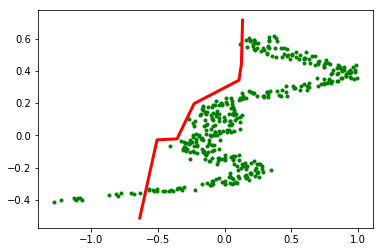

In [3]:
max_points = 7
lr=0.1
spline = tsp.Spline1D(max_points, x, y)
plt.scatter(y, x, marker='.', color='g')
plt.plot(spline.Y, spline.X, color='r', lw=3)

## Reverse Function 

In [4]:
def reverse0(self:tsp.Spline1D, y):
    x = np.zeros_like(self.input)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        x += xpossible*self.rangeX[i]
    return x

def reverse1(self:tsp.Spline1D, y, rangeY=None):
    if rangeY is None:
        rangeY = _calculate_rangeY_(self, y)
        
    x = np.zeros_like(self.rangeX)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        x[i] = xpossible*rangeY[i]
    return x


def _calculate_rangeY_(self:tsp.Spline1D, y):
    rangeY = np.zeros((self.n_points-1, y.shape[0]))
    
    def _inrange2_(X, break0, break1): #if x is after
        xmsk1 = X >= break0
        xmsk2 = X < break1
        xmsk12 = np.bitwise_and(xmsk1, xmsk2)
        xmsk3 = X < break0
        xmsk4 = X >= break1
        xmsk34 = np.bitwise_and(xmsk3, xmsk4)
        xs = np.bitwise_or(xmsk12, xmsk34)
        return xs

    for i in range(self.n_points-1):
        if self.n_points-2 == 0:
            rangeY[i] = _inrange2_(y, -np.inf, np.inf)
        elif i==0:
            sign = -1 if self.Y[0]<self.Y[1] else 1
            rangeY[i] = _inrange2_(y, sign*np.inf, self.Y[1])
        elif i== self.n_points-2:
            sign = 1 if self.Y[i]<self.Y[i+1] else -1
            rangeY[i] = _inrange2_(y, self.Y[i], sign*np.inf)
        else:
            rangeY[i] = _inrange2_(y, self.Y[i], self.Y[i+1])
    notInRange = np.where(rangeY.sum(axis=0) == 0)[0]
    #### for the values of y that are missed by the whole curve
    rangeY[:, notInRange] = self.rangeX[:, notInRange]
    return rangeY

def reverse_min_error0(self:tsp.Spline1D, y, x, rangeY=None):
    if rangeY is None:
        rangeY = _calculate_rangeY_(self, y)
        
    x_ = np.zeros_like(y)
    min_error = np.ones_like(y)*99999
    
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        error = np.abs(xpossible- x)
        candidate = np.nonzero((error < min_error)*rangeY[i])
        min_error[candidate] = error[candidate]
        x_[candidate] = xpossible[candidate]
    return x_

def reverse_min_error1(self:tsp.Spline1D, y, x):
    x_ = reverse1(spline, y)
    y_list = []
    for xi in x_:
        y_ = self.forward(xi)
        y_list.append(y_)

    indx_of_min_error = np.empty_like(y, dtype=np.int64)
    min_error = np.ones_like(y)*99999
    for indx, y_ in enumerate(y_list):
        dy_ = np.abs(y_ - y)
        candidate = np.nonzero(dy_ < min_error)
        min_error[candidate] = dy_[candidate]
        indx_of_min_error[candidate] = indx
#     indx_of_min_error
    newx_ = np.empty_like(x)
    for indx, xi in enumerate(x_):
        mask = indx_of_min_error == indx
        newx_[mask] = xi[mask]
    return newx_

### Reverse using the target

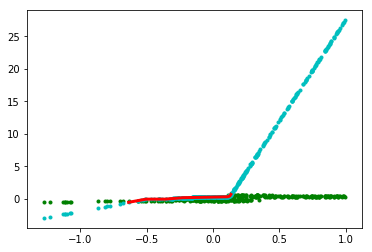

In [5]:
y_ = spline.forward(x)
# x_ = reverse_min_error0(spline, y, x)
x_ = reverse_min_error1(spline, y, x)

%matplotlib inline
plt.scatter(y, x, marker='.', color='g')
plt.plot(spline.Y, spline.X, color='r', lw=3)
plt.scatter(y, x_, marker='.', color='c')

## Finding gradients of spline points wrt gradient of inverse function

In [6]:
def _backward_X_(self:tsp.Spline1D, target, del_recons):

    consts = np.zeros((self.n_points-1, target.shape[0]))
    for i in range(self.n_points-1):
        consts[i] = (target-self.Y[i])/self.diffY[i]

    dX = np.zeros((self.n_points, target.shape[0]))

    dX[0] = (-1* consts[0] +1) *self.rangeX[0]
    dX[-1] = consts[-1] *self.rangeX[-1]

    for i in range(1, self.n_points-1):
            a = consts[i-1]*self.rangeX[i-1]
            b = (-1* consts[i] +1)*self.rangeX[i]
            dX[i] = a+b
    dX = dX*del_recons
    dX = dX.mean(axis=1)
    return dX

def _backward_Y_(self:tsp.Spline1D, target, del_recons):

    consts = np.zeros((self.n_points-1, target.shape[0]))
    for i in range(self.n_points-1):
        consts[i] = self.diffX[i]/(self.diffY[i]**2)

    dY = np.zeros((self.n_points, target.shape[0]))
    dY[0] = consts[0]*(target - self.Y[1])*self.rangeX[0]
    dY[-1] = -1*consts[-1]*(target - self.Y[-2])*self.rangeX[-1]

    for i in range(1, self.n_points-1):
            a = -1*consts[i-1]*(target - self.Y[i-1])*self.rangeX[i-1]
            b = consts[i]*(target - self.Y[i+1])*self.rangeX[i]
            dY[i] = a+b
    dY = dY*del_recons
    dY = dY.mean(axis=1)
    return dY


def _backward_target_(self:tsp.Spline1D, del_recons):
    dtarg = np.zeros_like(self.output)
    for i in range(self.n_points-1):
        dtarg = dtarg + self.diffX[i]/self.diffY[i] *self.rangeX[i]

    dtarg = dtarg*del_recons
    return dtarg

In [7]:
# Y = spline.forward(x)
# x_ = reverse_min_error0(spline, y, x)
# dx_ = x - x_
# dy_ = _backward_target_(spline, dx_)

# plt.scatter(y, x, marker='.', color='g')
# plt.plot(spline.Y, spline.X, color='r', lw=3)
# plt.scatter(y, dx_, marker='.', color='c')
# plt.scatter(y, dy_, marker='.', color='pink')

## Doing the optimization continuously

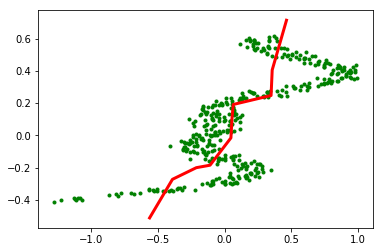

In [10]:
max_points = 10
lr=0.1
spline = tsp.Spline1D(max_points, x, y)
%matplotlib inline
plt.scatter(y, x, marker='.', color='g')
plt.plot(spline.Y, spline.X, color='r', lw=3)

_______________________
Steps 0
ErrorY 83.59219404460167
ErrorX 10.167421622723682
Error 93.75961566732535


_______________________
Steps 100
ErrorY 0.017039114524777996
ErrorX 0.21302317040962204
Error 0.23006228493440004


_______________________
Steps 200
ErrorY 7.418582875344401e-05
ErrorX 0.04177628348956668
Error 0.04185046931832013


_______________________
Steps 300
ErrorY 3.9134431700076506e-05
ErrorX 0.018645109444451417
Error 0.018684243876151495


_______________________
Steps 400
ErrorY 4.037848312327978e-05
ErrorX 0.01740060046997536
Error 0.017440978953098638


_______________________
Steps 500
ErrorY 4.592098556936713e-05
ErrorX 0.01618918492551645
Error 0.016235105911085818


_______________________
Steps 600
ErrorY 4.902476402463838e-05
ErrorX 0.01549944795940477
Error 0.015548472723429409


_______________________
Steps 700
ErrorY 5.0196243022652334e-05
ErrorX 0.014727019279940596
Error 0.014777215522963249


_______________________
Steps 800
ErrorY 5.14025786980259

TclError: invalid command name "pyimage33"

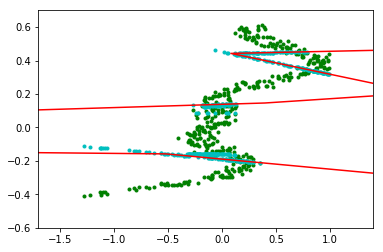

In [11]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for step in range(100000):

    Y = spline.forward(x)
    dy = Y-y
    dx = spline.backward(dy)
    
#     Y = spline.forward(x)
#     x_ = reverse_min_error0(spline, y, x)
#     x_ = reverse_min_error1(spline, y, x)
    x_ = reverse0(spline, y)
    dx_ = x_ - x
    
    Y_ = spline.forward(x_)
    del_X_inv = _backward_X_(spline, y, dx_)
    del_Y_inv = _backward_Y_(spline, y, dx_)
    dy_ = _backward_target_(spline, dx_)

#     dx = spline.backward(dy_)
    
    
    spline.del_X += del_X_inv
    spline.del_X/=2
    spline.del_Y += del_Y_inv
    spline.del_Y/=2
    
#     spline.del_X = del_X_inv
# #     spline.del_X = del_X_inv*0.
#     spline.del_Y = del_Y_inv
# #     spline.del_Y = del_Y_inv*0.
    
    
    spline.update(lr)
    ## for integrity of api only
    spline.backward(dy_)
    if step % 1000 == 0:
        spline._remove_close_points_()
        spline._combine_linear_points_()
        spline._remove_no_input_points_()
        spline._add_new_point_()
        
    if step % 100 == 0:            
        errory = (dy_**2).mean()
        errorx = (dx_**2).mean()
        error = errorx+ errory
        print('_______________________')
        print("Steps", step)
        print("ErrorY", errory)
        print("ErrorX", errorx)
        print("Error", error)
        
        ax.clear()
        plt.xlim(-1.7,1.4)
        plt.ylim(-0.6,0.7)
        plt.scatter(y, x, marker='.', color='g')
        plt.plot(spline.Y, spline.X, color='r')
#         plt.scatter(y, dx_, marker='.', color='c')
        plt.scatter(y, x_, marker='.', color='c')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

In [ ]:
plt.scatter(y, x, marker='.', color='g')
plt.plot(spline.Y, spline.X, color='r')
plt.scatter(y, dx_, marker='.', color='c')

In [ ]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, marker='.', color='r')